In [111]:
import numpy as np
import matplotlib.pyplot as plt
import graphlearning as gl
from scipy.optimize import minimize, LinearConstraint

Generate a sample of size 2 * n containing n data points from each class.
All data points are sampled from a dim-dimensional Gaussian.

[[3.1 3.6]
 [1.6 3.2]
 [2.6 2.4]
 [3.2 3.5]
 [3.7 2. ]
 [2.5 3.2]
 [2.7 1.4]
 [4.4 1.1]]


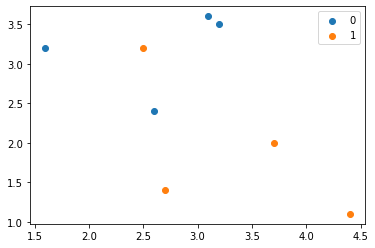

In [78]:
n = 4 # Sample size from each class
dim = 2
data = np.zeros((2 * n, dim))
mean1, cov1 = [2, 4], (1/2) * np.identity(dim)
mean2, cov2 = [4,2], (1/2) * np.identity(dim)
np.random.seed(1)
data[:n] = np.random.multivariate_normal(mean1, cov1, n)
np.random.seed(2)
data[n:] = np.random.multivariate_normal(mean2, cov2, n)

data = np.around(data, 1) #Round data to 1 decimal
#np.random.multivariate_normal([2,4], np.identity(dim), 10)
plt.scatter(data[:n, 0], data[:n, 1], label = '0')
plt.scatter(data[n:, 0], data[n:, 1], label = '1')
plt.legend()
print(data)

In [92]:
W = gl.weightmatrix.epsilon_ball(data, 1)
G = gl.graph(W)
print(W.toarray())

[[1.         0.         0.         0.92311635 0.         0.12493021
  0.         0.        ]
 [0.         1.         0.         0.         0.         0.0391639
  0.         0.        ]
 [0.         0.         1.         0.         0.         0.07427358
  0.         0.        ]
 [0.92311635 0.         0.         1.         0.         0.09827359
  0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.        ]
 [0.12493021 0.0391639  0.07427358 0.09827359 0.         1.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.        ]]


Calculate $$I[u] = \frac{1}{p} \sum_{i,j=1}^n | \nabla u(x_i,x_j) |^p + \sum_{j=1}^m(y_j - \bar{y} \cdot u(x_j) )$$

In [115]:
def penergy(u, G, y, p):
    gradu = G.gradient(u, weighted = True)
    first_summand = (1/p) * (np.absolute(gradu)**p).sum()
    y_bar = (1/y.size) * y.sum()
    second_summand = (y - y_bar * u).sum()
    return first_summand + second_summand

In [122]:
u = np.arange(n * 2)
y = np.zeros(n * 2)
y[n:] = np.ones(n)
print(penergy(u, G, y, 2))

1.0


In [118]:
def debug_penergy(u, G, y, p):
    gradu = G.gradient(u, weighted = True)
    print("Values of u: \n", u)
    print("Gradient = \n", gradu.toarray())
    first_summand = (1/p) * (np.absolute(gradu)**p).sum()
    y_bar = (1/y.size) * y.sum()
    second_summand = (y - y_bar * u).sum()
    print("First summand ", first_summand, " Second summand ", second_summand)
    return first_summand + second_summand

W = np.ones((3,3))
G = gl.graph(W)
y = np.array([0, 1, 0])
u = np.arange(3)
p = 2
print(debug_penergy(u, G, y, p))


Values of u: 
 [0 1 2]
Gradient = 
 [[ 0.  1.  2.]
 [-1.  0.  1.]
 [-2. -1.  0.]]
First summand  11.0  Second summand  1.1102230246251565e-16
11.0


In [127]:
linear_constraint = LinearConstraint(G.degree_vector(), [0], [0])
print(G.degree_vector())
minimize(penergy, x0 = np.zeros(n*2), args = (G, y, p), method = 'trust-constr', constraints = linear_constraint)

[3. 3. 3.]


ValueError: shapes (1,3) and (8,) not aligned: 3 (dim 1) != 8 (dim 0)